In [1]:
import stan
import pandas as pd
import nest_asyncio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nest_asyncio.apply()

In [15]:
schools_code = """

data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
  vector[T] X;
  
  vector[T] D_sun;
  vector[T] D_sat;
  vector[T] D_mon;
}

parameters {
  real mu;
  real psi;
  real d_sat;
  real d_sun;
  real d_mon;

  vector[T] epsilon_1;
  vector[T] epsilon_2;

  real<lower=0> eta_u;
  real<lower=0> eta_d;

  real kappa_hs;
  real<lower=0> omega_h;
  real<lower=-1,upper=1> phi_h;
  real theta_h;

  // vector[3] alpha;
  array[T] simplex[3] q;

  vector[T] J_s;
  vector[T] h_s;
}
transformed parameters { 
  vector[T] J = J_s;
  vector[T] h = h_s;
  vector<lower=0>[T] xi_d;
  vector<lower=0>[T] xi_u;
  real kappa_h;

  if (kappa_hs > 2) {
    kappa_h = 0;
  }
  else if (kappa_hs < 0) {
    kappa_h = 0;
  }
  else {
    kappa_h = kappa_hs;
  }

  for (t in 1:T) {
    xi_d[t] = exp(eta_d);
    xi_u[t] = exp(eta_u);
  }

  for (t in 1:T) {
    J[t] = -xi_d[t] * q[t][1] + 0 * q[t][2] + xi_u[t] * q[t][3];
  }

  h[1] = 0;
  for (t in 2:T) {
    h[t] = h[t-1] + kappa_h * (theta_h - h[t-1]) + phi_h * epsilon_1[t] + sqrt(omega_h) * epsilon_2[t];
  }
}
model {
  // Prior
  mu ~ normal(0, 10);
  psi ~ normal(0, 10);

  d_sat ~ normal(0, 10);
  d_sun ~ normal(0, 10);
  d_mon ~ normal(0, 10);

  kappa_hs ~ normal(1, 6);

  omega_h ~ inv_gamma(3, 0.05);
  phi_h ~ normal(0, 0.5 * omega_h);
  theta_h ~ normal(0, 10);

  eta_u ~ inv_gamma(1.86, 0.43);
  eta_d ~ inv_gamma(1.86, 0.43);

  //alpha = rep_vector(1, 3);
  for (t in 1:T) {
    q[t] ~ dirichlet(rep_vector(1, 3));
  }

  for (t in 1:T) {
    epsilon_1[t] ~ normal(0, 1);
    epsilon_2[t] ~ normal(0, 1);
  }
}
generated quantities {  
  vector[T] y_rep = y;
  for (t in 2:T) {
    y_rep[t] = y[t-1] + mu + psi * X[t] + epsilon_1[t] * sqrt(exp(h[t-1])) + J[t] + d_sat * D_sat[t] + d_sun * D_sun[t] + d_mon * D_mon[t];
    //+ mu
    //+ psi * X[t]
    //+ epsilon_1[t] * sqrt(exp(h[t-1]))
    //+ J[t]
    //+ d_sat * D_sat[t] + d_sun * D_sun[t] + d_mon * D_mon[t]
  }
}
"""

data = { 
    "T": 730,
    "y": np.log(pd.read_csv('/home/tim/dv/bsv_inference/data/hour_4.csv')['price']).to_numpy(),
    "X": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/df_temp4.csv', usecols=['log_temp']).to_numpy()),

    "D_sun": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/sundays.csv').to_numpy()),
    "D_sat": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/saturdays.csv').to_numpy()),
    "D_mon": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/mondays.csv').to_numpy())
    }

posterior = stan.build(schools_code, data=data)
fit = posterior.sample()
df = fit.to_frame()  # pandas `DataFrame, requires pandas

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_29lecq47/model_sjatm62p.stan', line 79, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_29lecq47/model_sjatm62p.stan', line 47, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_29lecq47/model_sjatm62p.stan', line 44, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    calculation.
    calculation.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  1

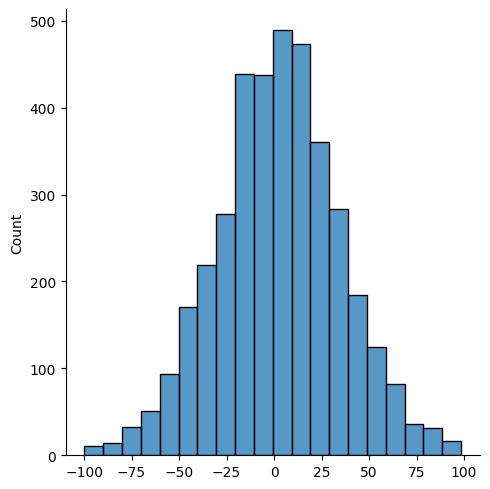

In [16]:
no_outliers = [n for n in df['y_rep.700'].to_numpy() if (-100 < n < 100)]
sns.displot(no_outliers, bins=20)
plt.show()

In [17]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,psi,d_sat,...,y_rep.721,y_rep.722,y_rep.723,y_rep.724,y_rep.725,y_rep.726,y_rep.727,y_rep.728,y_rep.729,y_rep.730
draws,,,,,,,,,,,,,,,,,,,,,
0,-4032.573667,0.853039,0.144174,10.0,1023.0,0.0,6209.784739,5.639761,-7.296729,10.051467,...,-16.998637,-8.159911,-10.965162,16.419912,-14.559384,-15.618035,-17.035910,-17.000448,-8.340572,-12.666230
1,-3979.826190,0.875379,0.171688,10.0,1023.0,0.0,6083.466475,2.969188,1.276845,0.547824,...,10.723555,10.773215,0.083991,26.022186,10.263869,9.037028,10.724035,8.582066,9.580684,0.485987
2,-4038.625824,0.841028,0.138744,10.0,1023.0,0.0,6220.891295,9.149538,10.026562,-6.083783,...,44.420366,36.074389,47.096543,54.687854,46.462071,43.356469,39.942226,44.162534,38.145269,50.310794
3,-4000.827877,0.989726,0.168298,10.0,1023.0,0.0,6219.613739,-4.773163,-4.253823,6.521629,...,-15.364067,-11.017519,-25.260206,-27.994101,-15.540067,-17.918933,-16.409001,-16.783606,-11.978143,-23.897558
4,-3994.991313,0.948154,0.144174,10.0,1023.0,0.0,6216.584347,7.378501,12.953754,-1.676788,...,57.178317,47.827994,52.189008,69.069443,49.073141,51.948579,52.640447,53.677857,52.331070,52.359323


In [18]:
log_prices_arr = []
for i in range(1, 730):
    log_prices_arr.append(np.median(df[f'y_rep.{i}']))

In [19]:
prices = np.exp(log_prices_arr)

In [20]:
# Define initial date
initial_date = '2022-01-01'
# Define number of days
num_days = 729

# Create datetime range starting from initial date
date_range = pd.date_range(start=initial_date, periods=num_days)

# Generate some sample values
values = log_prices_arr  # Random values between 0 and 100

# Create a DataFrame with datetime and corresponding values
res_df = pd.DataFrame({'Datetime': date_range, 'LogPrices': values, 'Prices': prices})
res_df['LogDiff'] = np.log(res_df['Prices']).diff()

print(res_df)

      Datetime  LogPrices     Prices   LogDiff
0   2022-01-01   2.301575   9.989900       NaN
1   2022-01-02   2.527991  12.528315  0.226417
2   2022-01-03   1.929672   6.887254 -0.598319
3   2022-01-04   3.035843  20.818510  1.106170
4   2022-01-05   2.914424  18.438192 -0.121418
..         ...        ...        ...       ...
724 2023-12-26   2.913663  18.424168  0.571954
725 2023-12-27   2.818010  16.743490 -0.095654
726 2023-12-28   3.353907  28.614308  0.535897
727 2023-12-29   2.481899  11.963965 -0.872008
728 2023-12-30   2.752597  15.683311  0.270698

[729 rows x 4 columns]


In [21]:
import matplotlib.pyplot as plt
def plot_ts(dataframe, col):
    # Plot the time series data
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe['Datetime'], dataframe[col], linestyle='-', color='black', linewidth = 0.5)
    # plt.axvline(x=pd.to_datetime('2023-08-24'), color='red', linestyle='--', label='Vertical Line')
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

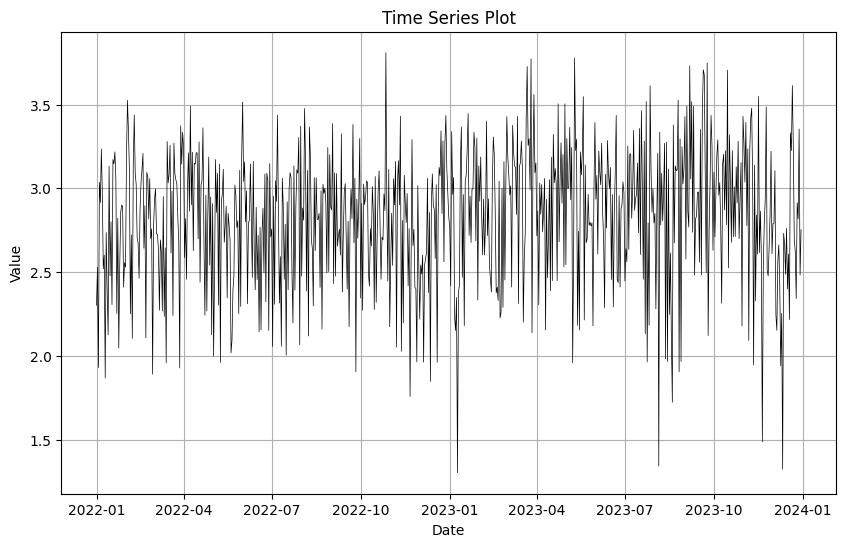

In [22]:
plot_ts(res_df, 'LogPrices')

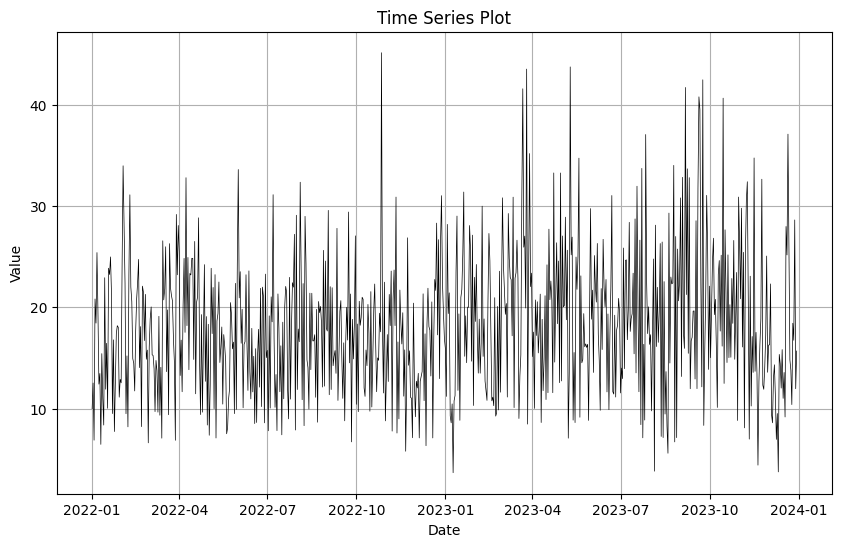

In [23]:
plot_ts(res_df, 'Prices')

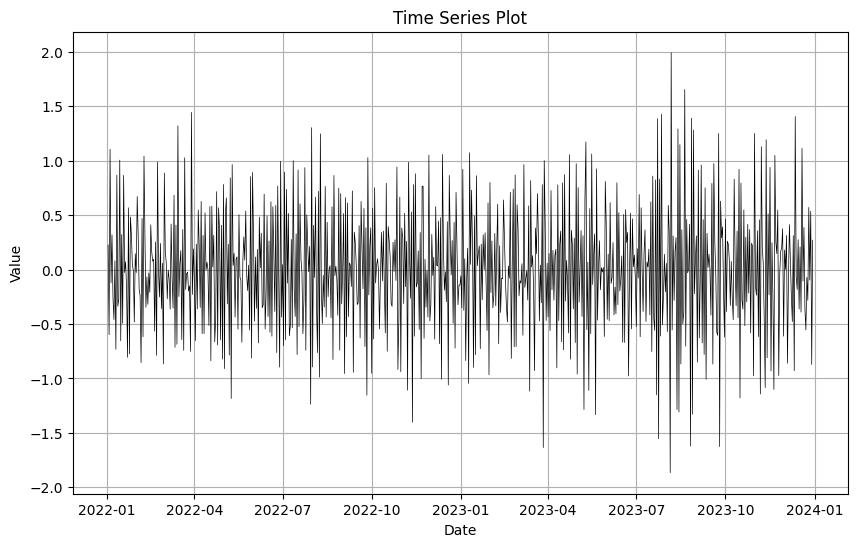

In [24]:
plot_ts(res_df, 'LogDiff')